## How bad is the scaling estimate for $\Phi_{Tr}$ for profiles other than linear?

Comparison between estimated tracer flux onto the shelf through the canyon and the real deal.

$\Phi_{Tr}=\Phi \bar{C}$

where $\frac{\Phi}{WUD_h} = 0.9\mathcal{F}_w^{3/2}R_o^{1/2}(1-1.21S_E)^3+0.07$, $\mathcal{F}_w=R_w/(0.9+R_w)$, $R_w=U/fW$, $S_E=sN/f(\mathcal{F}_w/R_o)^{1/2}$.

And, $\bar{C}$ is 
$\frac{\bar{C}}{C_0}= 0.02\frac{\partial_zC}{2} (H_s+H_r) + 0.94$

where
$\frac{\partial_zC}{\partial_zC_0}= 5.81\frac{Z+Z_{dif}}{H_s}+1.03$


In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

In [2]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [3]:
# Constants and scales

L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Wsb = 13000 # Width at shelf break
Hs = 147.5 # Shelf break depth
s = 0.005 # shelf slope 
W = 8300 # mid-length width
Hh = 97.5 # head depth
Hr = 132.0 # rim depth at DnS
No = 5.5E-3
f = 9.66E-5
kv = 1E-5
t = 6 # days
U = 0.35 # m/s

# NOTE: The default values of all functions correspond to the base case

def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U=0.37,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N=5.5E-3,f=9.66E-5,W=8300,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*W))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)


In [4]:
# Grid, state and tracers datasets of base case
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/gridGlob.nc'
grid = xr.open_dataset(grid_file)

state_file = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/stateGlob.nc' 
state = xr.open_dataset(state_file)

ptracers_file = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/ptracersGlob.nc'
ptracers = xr.open_dataset(ptracers_file)

ptracers_fileNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run02/ptracersGlob.nc'
ptracersNoC = xr.open_dataset(ptracers_fileNoC)

time = state.variables['T']


In [5]:
fileBAR = ('/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/HCW_TrMass_BARKLEY_run01.csv')
fileBARNoC = ('/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/HCW_TrMass_BARKLEY_run02.csv') 

fileLWR = ('/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOWER_SR_7Tr/HCW_TrMass_CNTDIFF_LOWER_SR_7Tr_run01.csv')
fileLWRNoC = ('/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOWER_SR_7Tr/HCW_TrMass_CNTDIFF_LOWER_SR_7Tr_run02.csv') 

dfBAR = pd.read_csv(fileBAR)
dfBARnoc = pd.read_csv(fileBARNoC)

dfLWR = pd.read_csv(fileLWR)
dfLWRnoc = pd.read_csv(fileLWRNoC)                

In [12]:
Mass_Bark = ['TrMassHCW01','TrMassHCW02','TrMassHCW03','TrMassHCW04',
             'TrMassHCW05','TrMassHCW06','TrMassHCW07','TrMassHCW08']
labels_Bark = ['Lin','Sal','Oxy','Nit','Sil','Pho','NitA','Met']
colours_Bark = ['purple','blue','green','gold','orange','red','orchid','teal']
dTr0_Bark = [ -0.0017,-0.001,0.186,-0.031,-0.047,-0.0013,-0.0067,-0.375]
Co_Bark = [32.24,33.89,104.070,32.60, 47.6260, 2.24576, 27.667, 17.5046 ]
Cd6_Bark = [32.2081,33.8268,112.498 ,31.67298 ,44.8990 ,2.17560 ,25.5802,16.2077]


Mass_Para = ['TrMassHCW01','TrMassHCW02','TrMassHCW03','TrMassHCW04',
             'TrMassHCW05','TrMassHCW06','TrMassHCW07']
labels_Para = ['Tr1','Tr2','Tr3','Tr4','Tr5','Tr6','Tr7']
colours_Para = ['0.1','0.2','0.3','0.4','0.5','0.6','0.7'] 
dTr0_Para = [-0.05,-0.059,-0.051,-0.049,-0.0427,-0.112,-0.0125]
Co_Para = [13.625,13.627 ,13.625 ,13.624 ,13.623,13.640, 150.10]
Cd6_Para =  [12.595 ,12.8862,12.6462,12.5458 ,12.3310 ,15.1507 ,146.4252] 


In [13]:
Z = ((f*U*F(Ro(U,f,R))*L)**(0.5))/No
Zdif = np.sqrt(t*3600*24*kv)
    
Se = (s*No)/(f*((F(Ro(U,f,W))/Ro(U,f,L))**(1/2)))
HA2013=(U*W*Dh(f,L,No))*((0.91*(F(Ro(U,f,W))**(3/2))*(Ro(U,f,L)**(1/2))*((1-1.21*Se)**3))+0.07)

Tracer	Phi err	C err
Tr1 	1.3	1.4
Tr2 	1.3	1.5
Tr3 	1.3	1.4
Tr4 	1.3	1.4
Tr5 	1.3	1.4
Tr6 	1.3	1.6
Tr7 	1.1	1.1
Lin 	0.9	1.0
Sal 	0.9	0.9
Oxy 	-0.5	-0.5
Nit 	1.1	1.2
Sil 	1.2	1.4
Pho 	0.9	1.0
NitA 	1.0	1.1
Met 	2.7	4.1


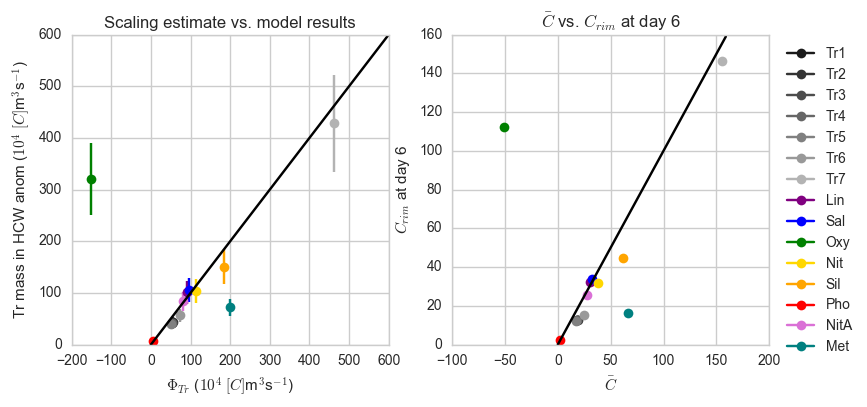

In [14]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(9,4))

print ("\t".join(['Tracer', 'Phi err', 'C err']))

for TrMass, dTr0,Co,C, lab, col in zip(Mass_Para,dTr0_Para,Co_Para,Cd6_Para,labels_Para,colours_Para):
    
    mass_can_eff = dfLWR[TrMass]-dfLWRnoc[TrMass]
    PhiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    PhiTr_std = np.std(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    dTrdz = -dTr0*(5.81*(((Z+Zdif)/Hs))+1.03)
    Capprox=((0.02*(dTrdz*(Hh+132.0)/2.0))+0.94)*Co
    scale_PhiTr = HA2013*Capprox
    ax1.errorbar(scale_PhiTr/1E4, PhiTr/1E4, yerr=PhiTr_std/1E4, color=col, label=lab, marker='o')
    err_phi = scale_PhiTr/PhiTr
    ax2.plot(Capprox, C, color=col, label=lab, marker='o')
    err_C = Capprox/C
    
    print ("%s" % (lab), "\t".join(['\t%1.1f\t%1.1f' % (err_phi, err_C)]))


for TrMass, dTr0, Co,C, lab, col in zip(Mass_Bark,dTr0_Bark,Co_Bark,Cd6_Bark,labels_Bark,colours_Bark):
    
    mass_can_eff = dfBAR[TrMass]-dfBARnoc[TrMass]
    PhiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    PhiTr_std = np.std(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    
    dTrdz = -dTr0*(5.81*(((Z+Zdif)/Hs))+1.03)
    Capprox=((0.02*(dTrdz*(Hh+132.0)/2.0))+0.94)*Co
    scale_PhiTr = HA2013*Capprox
    ax1.errorbar(scale_PhiTr/1E4, PhiTr/1E4, yerr=PhiTr_std/1E4, color=col, label=lab, marker='o')
    err_phi = scale_PhiTr/PhiTr
    ax2.plot(Capprox, C, color=col, label=lab, marker='o')
    err_C = Capprox/C
    print ("%s" % (lab), "\t".join(['\t%1.1f\t%1.1f' % (err_phi, err_C)]))

   
ax1.set_xlabel(r'$\Phi_{Tr}$ ($10^4$ $[C]$m$^{3}$s$^{-1}$)')
ax1.set_ylabel('Tr mass in HCW anom ($10^4$ $[C]$m$^{3}$s$^{-1}$)')
ax1.set_title('Scaling estimate vs. model results')
#ax1.set_ylim(0,500)
#ax1.set_xlim(0,500)
ax1.plot(np.arange(0,600,1),np.arange(0,600,1),'-k')

ax2.legend(bbox_to_anchor=(1.3,1),ncol=1, columnspacing=0.1)
ax2.set_xlabel(r'$\bar{C}$')
ax2.set_ylabel('$C_{rim}$ at day 6')
ax2.set_title(r'$\bar{C}$ vs. $C_{rim}$ at day 6')
ax2.plot(np.arange(0,160,1),np.arange(0,160,1),'-k')

Form this plot with a gigantic scale it is clear that our scaling does a pretty bad approximation for oxygen, methane, silicate and Tr7 (largest negative curvature) for both tracer flux and concentration near the rim. Also, the model comparison for concentration that I took ($C_{rim}$ at day 6) may not be very fair but it seems to be in good agreement of what happens for $\Phi_{Tr}$.

I will take the profiles that satisfy:

$$0.80 \le \frac{\Phi_{Tr}}{\Phi_{model}}\le 1.20$$

as cases where the model does a good job (within 20\% of model result)

So, the better ones are: Tr2, Tr6, Lin, Sal, Nit, Pho, and the bad ones are: Tr1 (!), Tr3, Tr4, Tr5, Tr7, Oxy, Sil, NitA, Met.

Tr1 should be good because it is a linear profile! 
Oxygen is terrible because it decreases with depth and the scaling cannot deal with that so far.

Also, the flux is mostly overestimated by the scaling, except for linear, salinity and phosphate.

(0, 55)

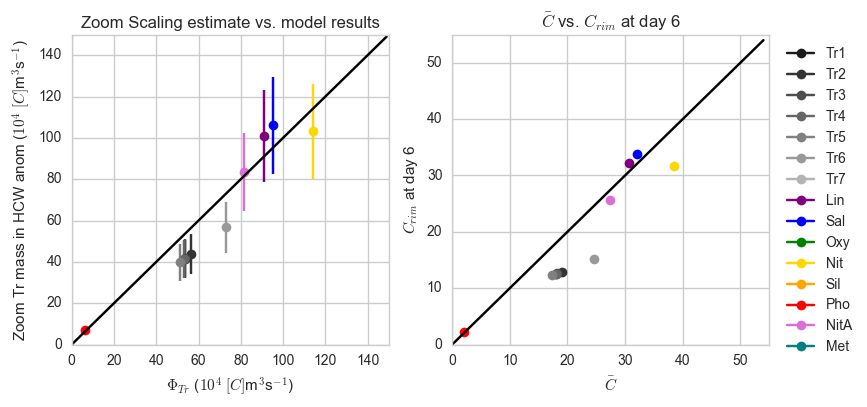

In [9]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(9,4))

for TrMass, dTr0,Co,C, lab, col in zip(Mass_Para,dTr0_Para,Co_Para,Cd6_Para,labels_Para,colours_Para):
    
    mass_can_eff = dfLWR[TrMass]-dfLWRnoc[TrMass]
    PhiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    PhiTr_std = np.std(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    
    dTrdz = -dTr0*(5.81*(((Z+Zdif)/Hs))+1.03)
    Capprox=((0.02*(dTrdz*(Hh+132.0)/2.0))+0.94)*Co
    scale_PhiTr = HA2013*Capprox
    ax1.errorbar(scale_PhiTr/1E4, PhiTr/1E4, yerr=PhiTr_std/1E4, color=col, label=lab, marker='o')
    ax2.plot(Capprox, C, color=col, label=lab, marker='o')

for TrMass, dTr0, Co,C, lab, col in zip(Mass_Bark,dTr0_Bark,Co_Bark,Cd6_Bark,labels_Bark,colours_Bark):
    
    mass_can_eff = dfBAR[TrMass]-dfBARnoc[TrMass]
    PhiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    PhiTr_std = np.std(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    
    dTrdz = -dTr0*(5.81*(((Z+Zdif)/Hs))+1.03)
    Capprox=((0.02*(dTrdz*(Hh+132.0)/2.0))+0.94)*Co
    scale_PhiTr = HA2013*Capprox
    
    ax1.errorbar(scale_PhiTr/1E4, PhiTr/1E4, yerr=PhiTr_std/1E4, color=col, label=lab, marker='o')
    ax2.plot(Capprox, C, color=col, label=lab, marker='o')

ax1.set_xlabel(r'$\Phi_{Tr}$ ($10^4$ $[C]$m$^{3}$s$^{-1}$)')
ax1.set_ylabel('Zoom Tr mass in HCW anom ($10^4$ $[C]$m$^{3}$s$^{-1}$)')
ax1.set_title('Zoom Scaling estimate vs. model results')
ax1.set_ylim(0,150)
ax1.set_xlim(0,150)
ax1.plot(np.arange(0,150,1),np.arange(0,150,1),'-k')

ax2.legend(bbox_to_anchor=(1.3,1),ncol=1, columnspacing=0.1)
ax2.set_xlabel(r'$\bar{C}$')
ax2.set_ylabel('$C_{rim}$ at day 6')
ax2.set_title(r'$\bar{C}$ vs. $C_{rim}$ at day 6')
ax2.plot(np.arange(0,55,1),np.arange(0,55,1),'-k')
ax2.set_ylim(0,55)
ax2.set_xlim(0,55)
